# Assignment 3, Part A
Multi-Layer Perceptron (MLP) neural network models developed to classify handwritten digits (0-9)
from the MNIST (Modified National Institute of Standards and Technology) Dataset. Models created
based on unique specifications for eachexperiment. The MLP model will be trained using the
Backpropagation algorithm that implemented using the mini-batch Stochastic Gradient Descent (SGD)
optimization algorithm.

Mini-batch size set to 64. Network trained to 50 epochs with early stopping enabled.

### MNIST (Modified National Institute of Standards and Technology) Dataset
Set of 70,000 small images of digits handwritten by high school students and employees of the US
Census Bureau. Each image is labeled with the digit it represents. The train set contains 60,000 
images, from which you should randomly select 5000 images as the validation set. 

##### Source:
- Data loaded directly using the Keras API: https://keras.io/api/datasets/mnist/ 

##### Input variables:
- 28x28=784 greyscale pixels
    - Pixel intensity: 0 (white) to 255 (black)

##### Output variable: 
- 10 classes representing integer values from 0 to 9


In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve

## Load Data & Display Dataset Information

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)
x_train Min: 0
x_train Max: 255
y_train Min: 0
y_train Max: 9
x_train dtype: uint8
y_train dtype: uint8
Training ( 0 ) -  5923 ; Test ( 0 ) -  980
Training ( 1 ) -  6742 ; Test ( 1 ) -  1135
Training ( 2 ) -  5958 ; Test ( 2 ) -  1032
Training ( 3 ) -  6131 ; Test ( 3 ) -  1010
Training ( 4 ) -  5842 ; Test ( 4 ) -  982
Training ( 5 ) -  5421 ; Test ( 5 ) -  892
Training ( 6 ) -  5918 ; Test ( 6 ) -  958
Training ( 7 ) -  6265 ; Test ( 7 ) -  1028
Training ( 8 ) -  5851 ; Test ( 8 ) -  974
Training ( 9 ) -  5949 ; Test ( 9 ) -  1009


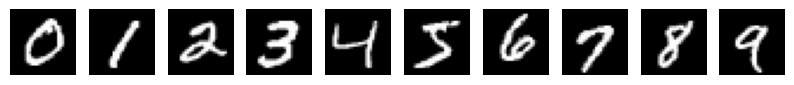

In [3]:
# Load the MNIST dataset using Keras
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Show the shape of the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# Print the minimum and maximum values of the training data
print("x_train Min:", np.min(x_train))
print("x_train Max:", np.max(x_train))
print("y_train Min:", np.min(y_train))
print("y_train Max:", np.max(y_train))

print("x_train dtype:", x_train.dtype)
print("y_train dtype:", y_train.dtype)

# Print the number of samples for each class
for i in range(10):
    print("Training (", i, ") - ", np.sum(y_train == i), "; Test (", i, ") - ", np.sum(y_test == i))

# Display the first training image for each class
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[y_train == i][0], cmap='gray')
    plt.axis('off')

## Data Pre-processing


In [4]:
# Normalize the input data
x_train, x_test = x_train / 255.0, x_test / 255.0

print("x_train Min:", np.min(x_train))
print("x_train Max:", np.max(x_train))
print("x_train dtype:", x_train.dtype)

x_train Min: 0.0
x_train Max: 1.0
x_train dtype: float64


In [5]:
# Convert the labels to the appropriate datatype for TensorFlow
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

## Data Analysis

In [6]:
def list_maximum_pairs_symmetric_matrix(sym_matrix, num_pairs):
    tmp = sym_matrix.copy()
    tmp = np.triu(tmp, k=1)

    print(f"Top {num_pairs} pairs:")
    for i in range(num_pairs):
        max_idx = np.unravel_index(np.argmax(tmp), tmp.shape)
        print(f"({max_idx[0]}, {max_idx[1]}) => {sym_matrix[max_idx]}")
        tmp[max_idx] = 0

Top 10 pairs:
(4, 9) => 0.8978909301898065
(5, 8) => 0.8688165934976697
(7, 9) => 0.8541372022126612
(3, 5) => 0.8488986033636338
(3, 8) => 0.8179677931758487
(8, 9) => 0.7985014177503245
(2, 8) => 0.7902616532929929
(2, 6) => 0.7696276051784255
(0, 5) => 0.7597062495955851
(5, 9) => 0.7525678937458707


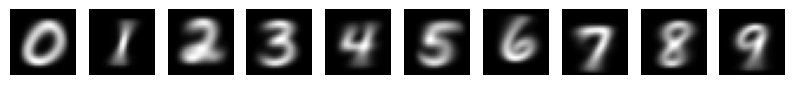

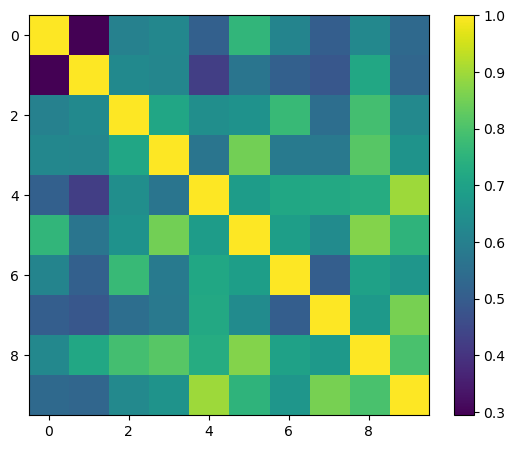

In [7]:
# Average the pixel values for each class
class_means = np.zeros((10, 28, 28))
for i in range(10):
    class_means[i] = np.mean(x_train[y_train == i], axis=0)

# Display the average images
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(class_means[i], cmap='gray')
    plt.axis('off')

# Look at the correlation between the average images of each class
corr = np.corrcoef(class_means.reshape(10, -1))

# Print the top 5 correlated pairs (excluding the diagonal and lower triangle)
list_maximum_pairs_symmetric_matrix(corr, 10)

# Display the correlation matrix as an image
plt.figure(figsize=(5,4))
plt.imshow(corr)
plt.colorbar()
plt.gca().set_aspect('auto')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0, wspace=0)


## Partition the Dataset into Train & Validation Subsets

In [8]:
# Randomly select 5000 samples from the training data for the training set
np.random.seed(42)
val_size = 5000
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=42, stratify=y_train)

# Show the shape of the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (55000, 28, 28)
y_train shape: (55000,)
x_val shape: (5000, 28, 28)
y_val shape: (5000,)


## Helper Functions
The following helper functions are inteded to be used througout all experiments.

In [9]:
def plot_learning_curves(history, title):
    numOfEpochs = history.epoch[-1]+1
    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation', color="r")
    plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training', color="b")
    plt.legend(loc=0, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Accuracy: "+title)
    
    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation', color="r")
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training', color="b")
    plt.legend(loc=0, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Loss: "+title)
    
    plt.show() 

In [10]:
def calculate_tar_at_far(y_true, y_pred, far, show_curve=False):
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    
    if show_curve:
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.show()
    
    return tpr[fpr >= far][0]

In [11]:
# Create an early stopping callback for use across all experiments
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='auto',
    min_delta=0,
    patience=10,
    restore_best_weights=True
)

In [12]:
def training_wrapper(ex_num, model, n_epochs, x_train, y_train, x_val, y_val, early_stop_cb):
    print(f"Starting Experiment {ex_num}...")
    print()
    print("**************************************************************************************")
    print("********************************    TRAINING MODEL    ********************************")
    print("**************************************************************************************")
    history = model.fit(
        x_train, 
        y_train, 
        epochs=n_epochs, 
        validation_data=(x_val, y_val), 
        callbacks=[early_stop_cb]
    )

    print()
    print("***************************************************************************************")
    print("******************************    EVALUATING TRAINING    ******************************")
    print("***************************************************************************************")
    print()
    plot_learning_curves(history, f"Experiment {ex_num}")

    return model, history

In [13]:
def evaluation_wrapper(ex_num, model, x_train, y_train, x_test, y_test, far_list=[], plot_roc=False):
    print(f"Starting Evaluation for Experiment {ex_num}...")
    
    y_pred = model.predict(x_test, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)
    
    print()
    print("**************************************************************************************")
    print("***************************    EVALUATING TRAINED MODEL    ***************************")
    print("**************************************************************************************")
    print()
    train_accuracy = accuracy_score(y_train, np.argmax(model.predict(x_train, verbose=0), axis=1))
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Train Accuracy: {np.round(train_accuracy, 4)}")
    print(f"Test Accuracy: {np.round(test_accuracy, 4)}")
    print()
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    # print()
    # print("Classification Report:")
    # print(classification_report(y_test, y_pred))
    
    print()
    print("***************************************************************************************")
    print("*********************************    EXTRA METRICS    *********************************")
    print("***************************************************************************************")
    print()
    for far in far_list:
        tar_at_far = calculate_tar_at_far(y_test, y_pred, far)
        print(f"TAR @ FAR={far*100}%: {np.round(tar_at_far, 4)*100}%")
    if plot_roc:
        print()
        _ = calculate_tar_at_far(y_test, y_pred, 0.01, show_curve=True)

    print()
    print("Misclassified digits...")
    # Using the confusion matrix, list the top ten most confused pairs of digits
    list_maximum_pairs_symmetric_matrix(conf_matrix, 10)
    
    return y_pred

## Experiment 1
Create a deep feed forward network with the following characteristics:
- 2 hidden layers 
    - Hidden layer 1: neurons=300 
    - Hidden layer 2: neurons=100
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): zeros
- activation (hidden layers): sigmoid
- Dropout (hidden layers): None
- Max 50 epochs with early exit

### Construct and Compile Model

In [14]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='sigmoid', kernel_initializer='zeros', name='hidden1'),
    tf.keras.layers.Dense(100, activation='sigmoid', kernel_initializer='zeros', name='hidden2'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='zeros', name='output')
])

optimizer_ex1 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex1 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex1.compile(optimizer=optimizer_ex1, loss=loss_fn_ex1, metrics=['accuracy'])

model_ex1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### Train Model

Starting Experiment 1...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
1719/1719 [==============================] - 4s 2ms/step - loss: 2.3091 - accuracy: 0.1062 - val_loss: 2.3028 - val_accuracy: 0.1044
Epoch 2/50
1719/1719 [==============================] - 2s 1ms/step - loss: 2.2002 - accuracy: 0.1843 - val_loss: 2.0008 - val_accuracy: 0.2640
Epoch 3/50
1719/1719 [==============================] - 3s 2ms/step - loss: 1.8910 - accuracy: 0.2985 - val_loss: 1.8052 - val_accuracy: 0.3094
Epoch 4/50
1719/1719 [==============================] - 3s 2ms/step - loss: 1.7473 - accuracy: 0.3335 - val_loss: 1.7106 - val_accuracy: 0.3270
Epoch 5/50
1719/1719 [==============================] - 3s 2ms/step - loss: 1.6790 - accuracy: 0.3518 - val_loss: 1.6647 - val_accuracy: 

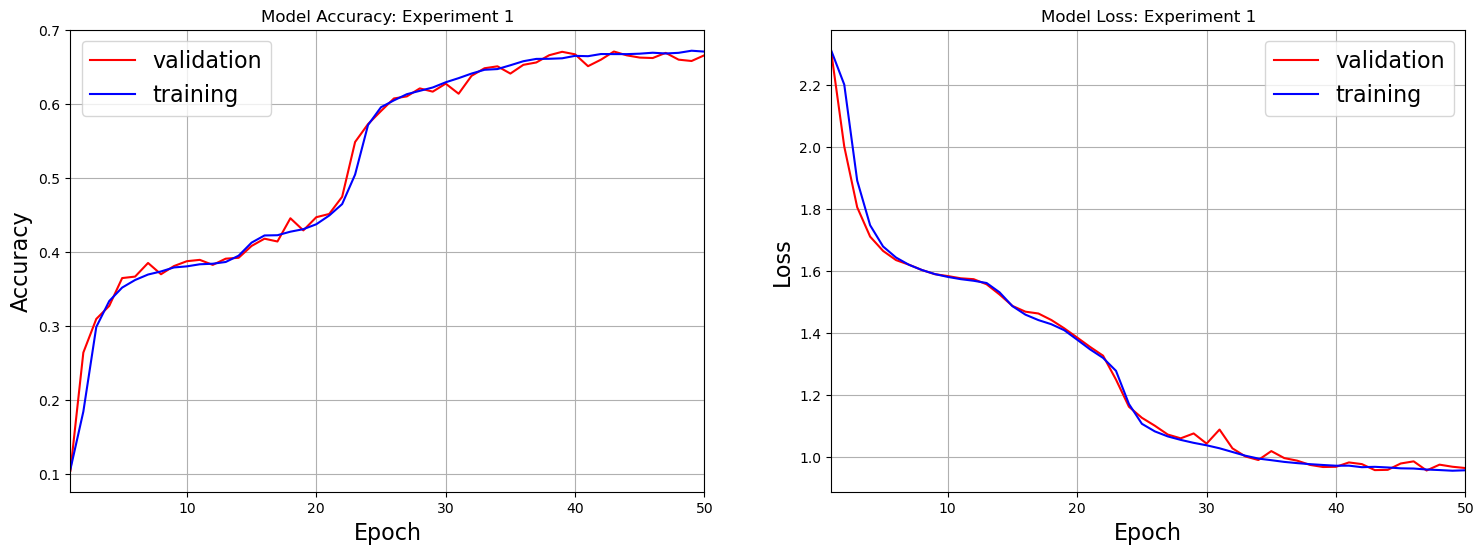

CPU times: total: 29min 11s
Wall time: 2min 33s


In [15]:
%%time
model_ex1, history_ex1 = training_wrapper(
    ex_num=1,
    model=model_ex1,
    n_epochs=50,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    early_stop_cb=early_stopping
)

### Evaluating Trained Model

In [16]:
y_pred_ex1 = evaluation_wrapper(
    ex_num=1,
    model=model_ex1,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 1...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.6749
Test Accuracy: 0.6755

Confusion Matrix:
[[ 809    0    1    2   11  121   32    0    3    1]
 [   0 1086   12   32    0    1    0    1    2    1]
 [   6   49  753  164    3   11   23    6   14    3]
 [   0   95  170  550   10   43   14   19   99   10]
 [  12    1    1    7  646   38    4   17   31  225]
 [  56    7   24   70  127  437   42    5  112   12]
 [  67    1   83   38    3   41  717    0    8    0]
 [   1   85    2   19   17    2    0  758    9  135]
 [  21   51   11  281   39  174   19   19  341   18]
 [   6    3    0    1  136   11    1  174   19  658]]

***************************************************************************************
*************

## Experiment 2
Create a deep feed forward network with the following characteristics:
- 2 hidden layers 
    - Hidden layer 1: neurons=300 
    - Hidden layer 2: neurons=100
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): ones
- activation (hidden layers): sigmoid
- Dropout (hidden layers): None
- Max 50 epochs with early exit

### Construct and Compile Model

In [17]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='sigmoid', kernel_initializer='ones', name='hidden1'),
    tf.keras.layers.Dense(100, activation='sigmoid', kernel_initializer='ones', name='hidden2'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='ones', name='output')
])

optimizer_ex2 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex2 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex2.compile(optimizer=optimizer_ex2, loss=loss_fn_ex2, metrics=['accuracy'])

model_ex2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### Train Model

Starting Experiment 2...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
1719/1719 [==============================] - 4s 2ms/step - loss: 2.4802 - accuracy: 0.1012 - val_loss: 2.5352 - val_accuracy: 0.0974
Epoch 2/50
1719/1719 [==============================] - 2s 1ms/step - loss: 2.4722 - accuracy: 0.1017 - val_loss: 2.4542 - val_accuracy: 0.0904
Epoch 3/50
1719/1719 [==============================] - 3s 2ms/step - loss: 2.4830 - accuracy: 0.1006 - val_loss: 2.4634 - val_accuracy: 0.1044
Epoch 4/50
1719/1719 [==============================] - 3s 2ms/step - loss: 2.4703 - accuracy: 0.1009 - val_loss: 2.5168 - val_accuracy: 0.1124
Epoch 5/50
1719/1719 [==============================] - 3s 2ms/step - loss: 2.4720 - accuracy: 0.1029 - val_loss: 2.5115 - val_accuracy: 

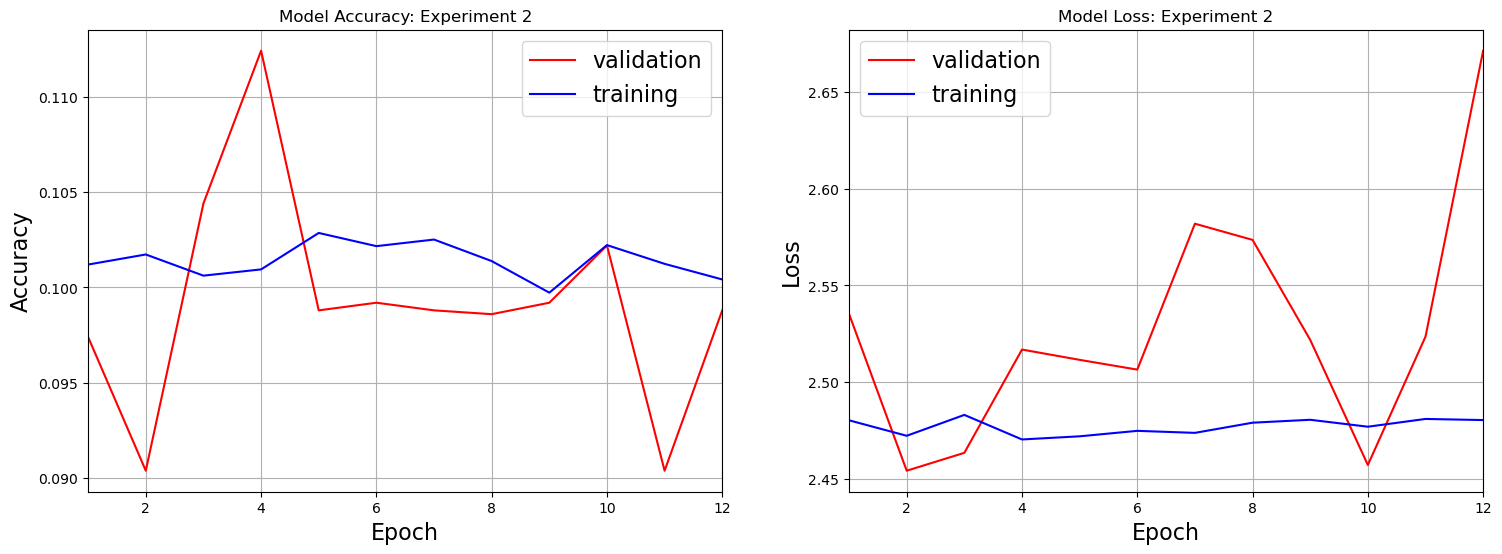

CPU times: total: 7min 23s
Wall time: 38.1 s


In [18]:
%%time
model_ex2, history_ex2 = training_wrapper(
    ex_num=2,
    model=model_ex2,
    n_epochs=50,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    early_stop_cb=early_stopping
)

### Evaluating Trained Model

In [19]:
y_pred_ex2 = evaluation_wrapper(
    ex_num=2,
    model=model_ex2,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 2...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.0903
Test Accuracy: 0.0892

Confusion Matrix:
[[   0    0    0    0    0  980    0    0    0    0]
 [   0    0    0    0    0 1135    0    0    0    0]
 [   0    0    0    0    0 1032    0    0    0    0]
 [   0    0    0    0    0 1010    0    0    0    0]
 [   0    0    0    0    0  982    0    0    0    0]
 [   0    0    0    0    0  892    0    0    0    0]
 [   0    0    0    0    0  958    0    0    0    0]
 [   0    0    0    0    0 1028    0    0    0    0]
 [   0    0    0    0    0  974    0    0    0    0]
 [   0    0    0    0    0 1009    0    0    0    0]]

***************************************************************************************
*************

## Experiment 3
Create a deep feed forward network with the following characteristics:
- 2 hidden layers 
    - Hidden layer 1: neurons=300 
    - Hidden layer 2: neurons=100
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): random_normal
- activation (hidden layers): sigmoid
- Dropout (hidden layers): None
- Max 50 epochs with early exit

### Construct and Compile Model

In [20]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex3 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='sigmoid', kernel_initializer='random_normal', name='hidden1'),
    tf.keras.layers.Dense(100, activation='sigmoid', kernel_initializer='random_normal', name='hidden2'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])

optimizer_ex3 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex3 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex3.compile(optimizer=optimizer_ex3, loss=loss_fn_ex3, metrics=['accuracy'])

model_ex3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### Train Model

Starting Experiment 3...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
1719/1719 [==============================] - 4s 2ms/step - loss: 1.1981 - accuracy: 0.6148 - val_loss: 0.4929 - val_accuracy: 0.8596
Epoch 2/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3882 - accuracy: 0.8890 - val_loss: 0.3488 - val_accuracy: 0.9014
Epoch 3/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3153 - accuracy: 0.9085 - val_loss: 0.3069 - val_accuracy: 0.9130
Epoch 4/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2779 - accuracy: 0.9177 - val_loss: 0.2777 - val_accuracy: 0.9200
Epoch 5/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2482 - accuracy: 0.9274 - val_loss: 0.2545 - val_accuracy: 

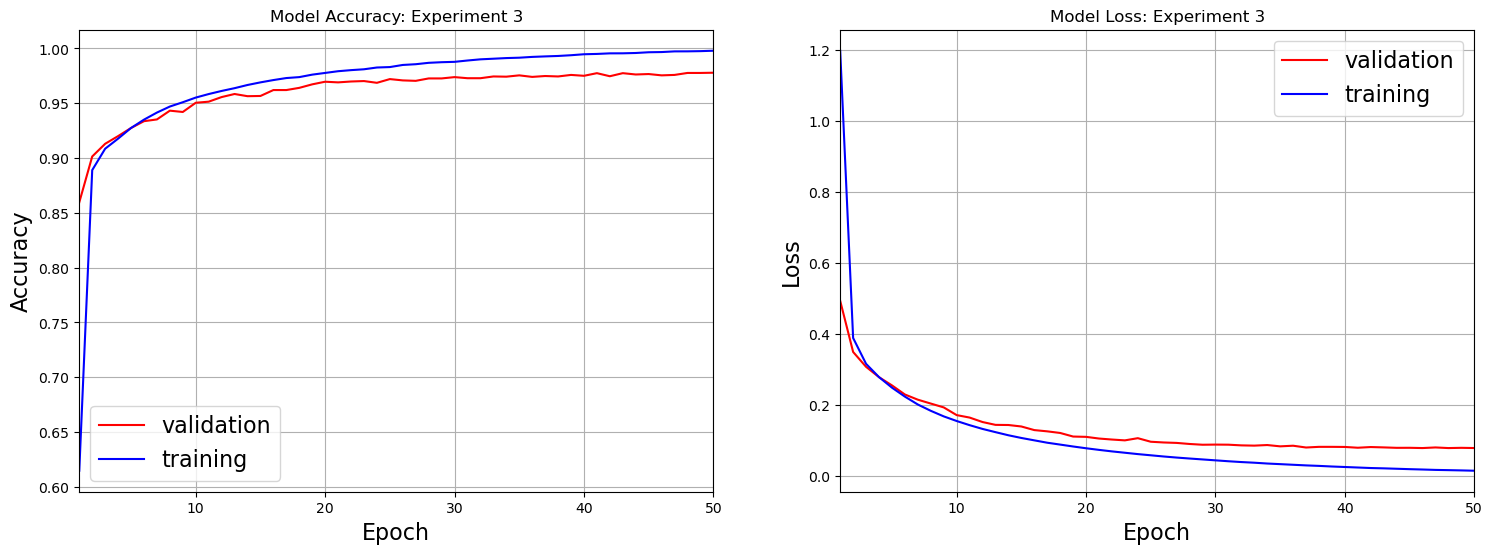

CPU times: total: 30min 10s
Wall time: 2min 34s


In [21]:
%%time
model_ex3, history_ex3 = training_wrapper(
    ex_num=3,
    model=model_ex3,
    n_epochs=50,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    early_stop_cb=early_stopping
)

### Evaluating Trained Model

In [22]:
y_pred_ex3 = evaluation_wrapper(
    ex_num=3,
    model=model_ex3,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 3...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9985
Test Accuracy: 0.979

Confusion Matrix:
[[ 971    0    1    1    1    1    2    1    1    1]
 [   0 1126    2    1    0    1    2    1    2    0]
 [   7    0 1004    7    1    0    1    4    8    0]
 [   0    0    1  999    0    2    0    3    4    1]
 [   2    0    1    1  955    0    5    1    2   15]
 [   2    0    0   12    2  864    4    1    3    4]
 [   5    3    2    1    3    2  939    0    3    0]
 [   1    6    7    7    1    0    1  994    2    9]
 [   3    0    3    4    1    4    2    1  953    3]
 [   2    2    0    5    4    0    1    3    7  985]]

***************************************************************************************
**************

## Experiment 4
Create a deep feed forward network with the following characteristics:
- 2 hidden layers 
    - Hidden layer 1: neurons=300 
    - Hidden layer 2: neurons=100
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): random_normal
- activation (hidden layers): tanh
- Dropout (hidden layers): None
- Max 50 epochs with early exit

### Construct and Compile Model

In [23]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex4 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='tanh', kernel_initializer='random_normal', name='hidden1'),
    tf.keras.layers.Dense(100, activation='tanh', kernel_initializer='random_normal', name='hidden2'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])

optimizer_ex4 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex4 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex4.compile(optimizer=optimizer_ex4, loss=loss_fn_ex4, metrics=['accuracy'])

model_ex4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### Train Model

Starting Experiment 4...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3433 - accuracy: 0.9029 - val_loss: 0.2305 - val_accuracy: 0.9302
Epoch 2/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1667 - accuracy: 0.9510 - val_loss: 0.1546 - val_accuracy: 0.9510
Epoch 3/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1180 - accuracy: 0.9648 - val_loss: 0.1239 - val_accuracy: 0.9618
Epoch 4/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0905 - accuracy: 0.9731 - val_loss: 0.1071 - val_accuracy: 0.9664
Epoch 5/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0713 - accuracy: 0.9790 - val_loss: 0.0973 - val_accuracy: 

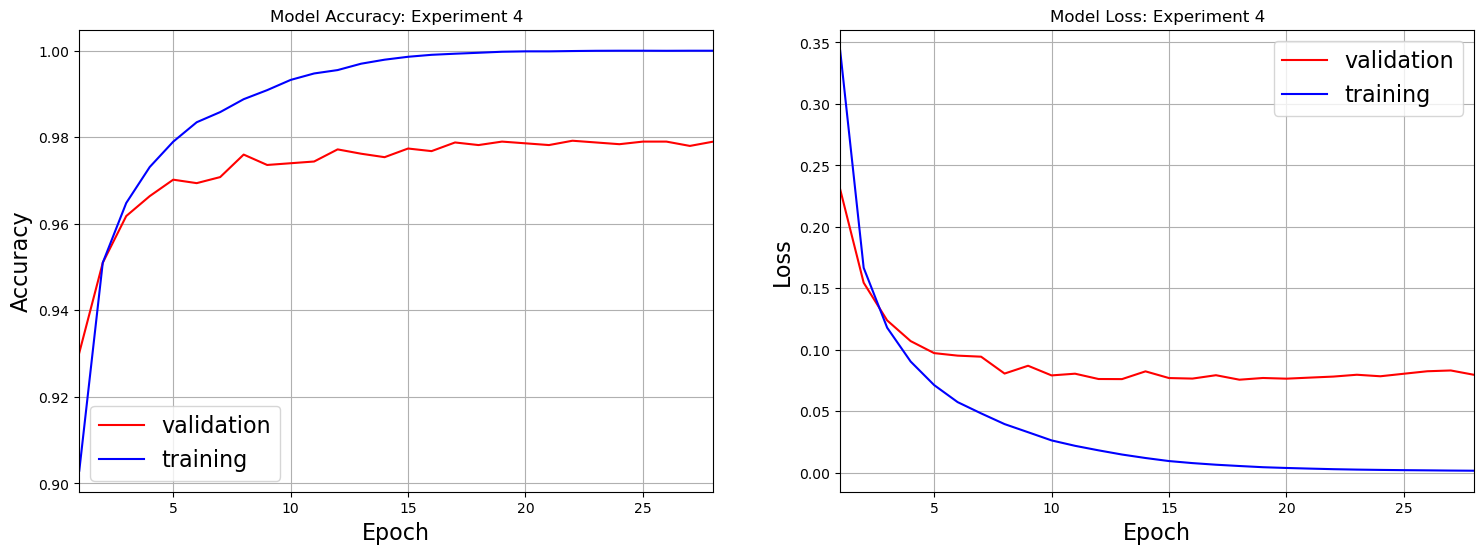

CPU times: total: 17min 36s
Wall time: 1min 30s


In [24]:
%%time
model_ex4, history_ex4 = training_wrapper(
    ex_num=4,
    model=model_ex4,
    n_epochs=50,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    early_stop_cb=early_stopping
)

### Evaluating Trained Model

In [25]:
y_pred_ex4 = evaluation_wrapper(
    ex_num=4,
    model=model_ex4,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 4...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9999
Test Accuracy: 0.9797

Confusion Matrix:
[[ 971    0    2    0    0    1    2    1    3    0]
 [   0 1125    0    2    0    1    2    1    3    1]
 [   4    1 1003    6    1    0    4    5    8    0]
 [   0    0    1  990    0    4    0    6    4    5]
 [   1    0    1    0  961    1    5    3    0   10]
 [   3    0    0    8    2  869    3    1    4    2]
 [   6    2    1    0    5    3  940    0    1    0]
 [   1    5    4    2    1    1    0 1001    6    7]
 [   3    0    1    3    3    5    1    3  953    2]
 [   3    2    0    6    6    0    0    7    1  984]]

***************************************************************************************
*************

## Experiment 5
Create a deep feed forward network with the following characteristics:
- 2 hidden layers 
    - Hidden layer 1: neurons=300 
    - Hidden layer 2: neurons=100
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): random_normal
- activation (hidden layers): relu
- Dropout (hidden layers): None
- Max 50 epochs with early exit

### Construct and Compile Model

In [26]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex5 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='random_normal', name='hidden1'),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='random_normal', name='hidden2'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])

optimizer_ex5 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex5 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex5.compile(optimizer=optimizer_ex5, loss=loss_fn_ex5, metrics=['accuracy'])

model_ex5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### Train Model

Starting Experiment 5...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3276 - accuracy: 0.9056 - val_loss: 0.1775 - val_accuracy: 0.9472
Epoch 2/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1210 - accuracy: 0.9636 - val_loss: 0.1182 - val_accuracy: 0.9614
Epoch 3/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0813 - accuracy: 0.9756 - val_loss: 0.0981 - val_accuracy: 0.9696
Epoch 4/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0598 - accuracy: 0.9817 - val_loss: 0.0870 - val_accuracy: 0.9714
Epoch 5/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0440 - accuracy: 0.9865 - val_loss: 0.0779 - val_accuracy: 

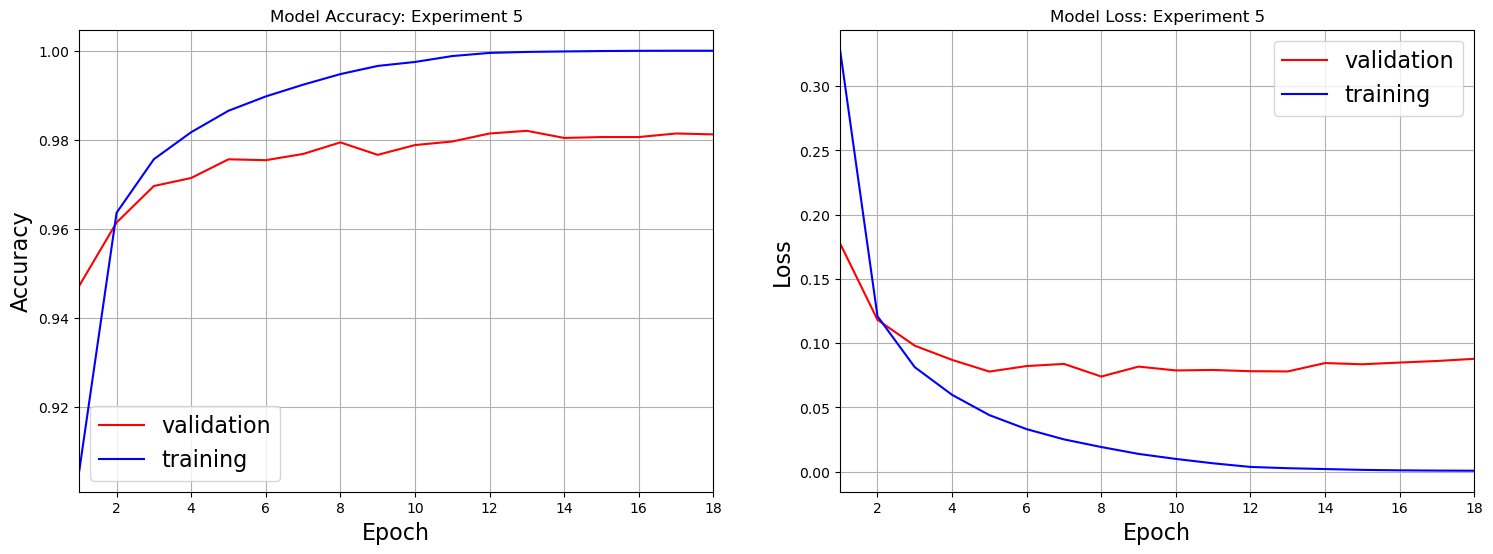

CPU times: total: 11min 1s
Wall time: 56.9 s


In [27]:
%%time
model_ex5, history_ex5 = training_wrapper(
    ex_num=5,
    model=model_ex5,
    n_epochs=50,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    early_stop_cb=early_stopping
)

### Evaluating Trained Model

In [28]:
y_pred_ex5 = evaluation_wrapper(
    ex_num=5,
    model=model_ex5,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 5...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9968
Test Accuracy: 0.9784

Confusion Matrix:
[[ 971    0    0    1    0    0    2    0    3    3]
 [   0 1123    4    2    0    0    2    1    3    0]
 [   6    0 1009    5    3    0    0    5    4    0]
 [   0    0    5  987    0    6    0    2    4    6]
 [   1    0    2    1  949    1    4    2    2   20]
 [   2    0    0   10    0  867    2    1    6    4]
 [   6    2    0    1    6    4  935    0    4    0]
 [   2    2    7    3    0    0    0  999    4   11]
 [   6    0    1    2    1    2    2    2  956    2]
 [   2    2    0    5    5    2    1    3    1  988]]

***************************************************************************************
*************

## Experiment 6
Create a deep feed forward network with the following characteristics:
- 2 hidden layers 
    - Hidden layer 1: neurons=300 
    - Hidden layer 2: neurons=100
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): random_normal
- activation (hidden layers): relu
- Dropout (hidden layers)
    - Hidden layer 1: rate=0.1
    - Hidden layer 2: rate=0.1
- Max 50 epochs with early exit

### Construct and Compile Model

In [29]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex6 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='random_normal', name='hidden1'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='random_normal', name='hidden2'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])

optimizer_ex6 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex6 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex6.compile(optimizer=optimizer_ex6, loss=loss_fn_ex6, metrics=['accuracy'])

model_ex6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trai

### Train Model

Starting Experiment 6...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3533 - accuracy: 0.8955 - val_loss: 0.1765 - val_accuracy: 0.9438
Epoch 2/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1379 - accuracy: 0.9577 - val_loss: 0.1294 - val_accuracy: 0.9616
Epoch 3/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0978 - accuracy: 0.9702 - val_loss: 0.0976 - val_accuracy: 0.9718
Epoch 4/50
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0772 - accuracy: 0.9768 - val_loss: 0.0924 - val_accuracy: 0.9718
Epoch 5/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0620 - accuracy: 0.9812 - val_loss: 0.0810 - val_accuracy: 

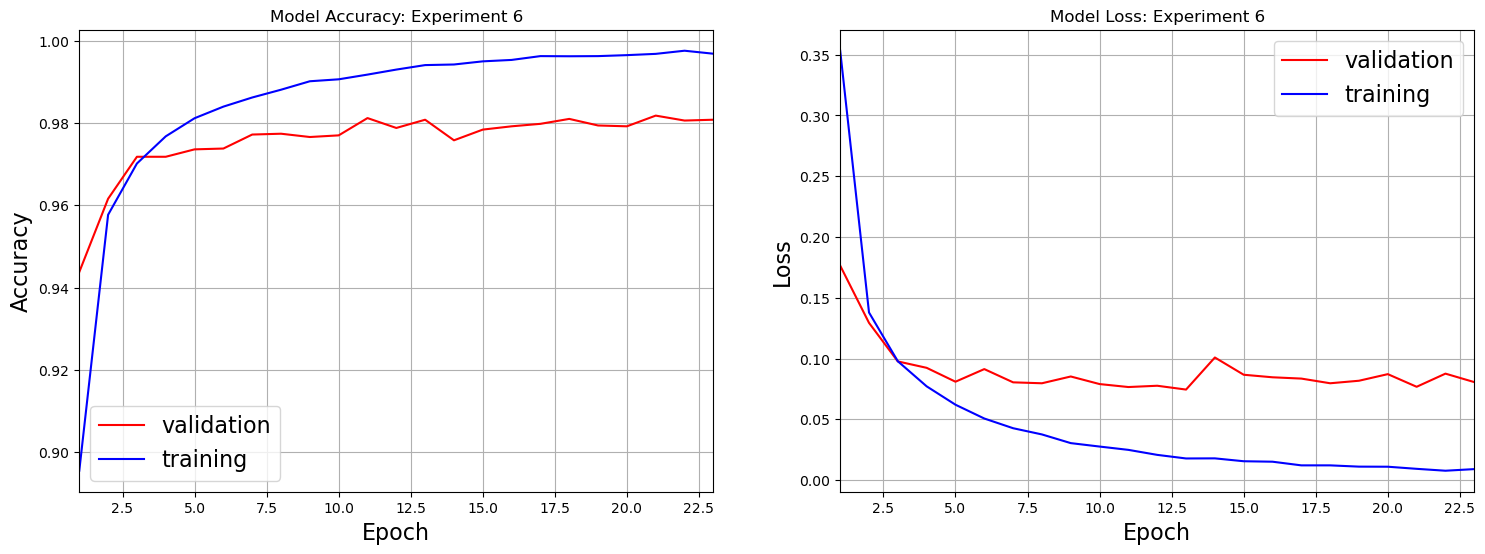

CPU times: total: 17min 13s
Wall time: 1min 28s


In [30]:
%%time
model_ex6, history_ex6 = training_wrapper(
    ex_num=6,
    model=model_ex6,
    n_epochs=50,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    early_stop_cb=early_stopping
)

### Evaluating Trained Model

In [31]:
y_pred_ex6 = evaluation_wrapper(
    ex_num=6,
    model=model_ex6,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 6...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9985
Test Accuracy: 0.9839

Confusion Matrix:
[[ 973    1    0    1    0    0    1    1    2    1]
 [   0 1126    3    2    0    0    2    0    2    0]
 [   3    0 1013    3    1    0    3    6    3    0]
 [   0    0    4  991    0    7    0    3    3    2]
 [   0    0    3    1  966    0    3    2    0    7]
 [   2    0    0    2    1  879    6    0    1    1]
 [   3    2    0    1    5    2  943    0    2    0]
 [   1    2    4    2    0    1    0 1008    2    8]
 [   3    0    1    7    2    2    1    4  949    5]
 [   1    2    0    2    7    3    0    3    0  991]]

***************************************************************************************
*************

## Experiment 7
Create a deep feed forward network with the following characteristics:
- 2 hidden layers 
    - Hidden layer 1: neurons=300 
    - Hidden layer 2: neurons=100
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): random_normal
- activation (hidden layers): relu
- Dropout (hidden layers)
    - Hidden layer 1: rate=0.5
    - Hidden layer 2: rate=0.1
- Max 50 epochs with early exit

### Construct and Compile Model

In [32]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex7 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='random_normal', name='hidden1'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='random_normal', name='hidden2'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])

optimizer_ex7 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex7 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex7.compile(optimizer=optimizer_ex7, loss=loss_fn_ex7, metrics=['accuracy'])

model_ex7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trai

### Train Model

Starting Experiment 7...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4331 - accuracy: 0.8659 - val_loss: 0.1904 - val_accuracy: 0.9398
Epoch 2/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2054 - accuracy: 0.9379 - val_loss: 0.1228 - val_accuracy: 0.9612
Epoch 3/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1622 - accuracy: 0.9500 - val_loss: 0.1045 - val_accuracy: 0.9682
Epoch 4/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1400 - accuracy: 0.9568 - val_loss: 0.0959 - val_accuracy: 0.9700
Epoch 5/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1225 - accuracy: 0.9622 - val_loss: 0.0874 - val_accuracy: 

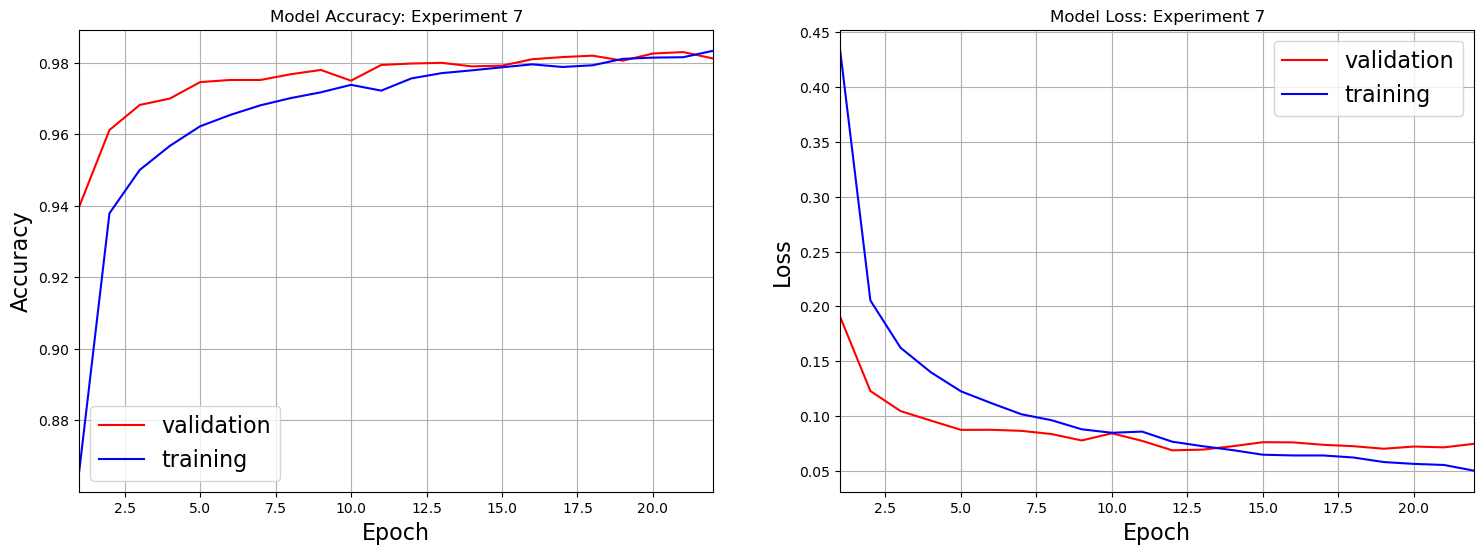

CPU times: total: 13min 34s
Wall time: 1min 7s


In [33]:
%%time
model_ex7, history_ex7 = training_wrapper(
    ex_num=7,
    model=model_ex7,
    n_epochs=50,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    early_stop_cb=early_stopping
)

### Evaluating Trained Model

In [34]:
y_pred_ex7 = evaluation_wrapper(
    ex_num=7,
    model=model_ex7,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 7...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.9923
Test Accuracy: 0.98

Confusion Matrix:
[[ 970    0    1    1    0    0    4    1    3    0]
 [   0 1125    2    1    0    1    4    0    2    0]
 [   4    1 1013    1    1    0    1    8    3    0]
 [   1    0    7  993    0    2    0    3    2    2]
 [   0    0    2    0  966    0    4    3    1    6]
 [   2    0    0   13    0  866    6    1    3    1]
 [   4    3    0    1    4    3  942    0    1    0]
 [   1    6    8    1    1    0    0 1001    3    7]
 [   3    0    2    8    3    2    3    4  946    3]
 [   2    3    0    9   10    0    1    5    1  978]]

***************************************************************************************
***************

## Experiment 8
Create a deep feed forward network with the following characteristics:
- 2 hidden layers 
    - Hidden layer 1: neurons=300 
    - Hidden layer 2: neurons=100
- SGD Learning Rate: 0.5
- kernel_initializer (all layers): random_normal
- activation (hidden layers): relu
- Dropout (hidden layers)
    - Hidden layer 1: rate=0.5
    - Hidden layer 2: rate=0.1
- Max 50 epochs with early exit

### Construct and Compile Model

In [35]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex8 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='random_normal', name='hidden1'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='random_normal', name='hidden2'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal', name='output')
])

optimizer_ex8 = tf.keras.optimizers.SGD(learning_rate=0.5)
loss_fn_ex8 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex8.compile(optimizer=optimizer_ex8, loss=loss_fn_ex8, metrics=['accuracy'])

model_ex8.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trai

### Train Model

Starting Experiment 8...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4500 - accuracy: 0.8647 - val_loss: 0.2050 - val_accuracy: 0.9390
Epoch 2/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2699 - accuracy: 0.9225 - val_loss: 0.1711 - val_accuracy: 0.9454
Epoch 3/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2383 - accuracy: 0.9313 - val_loss: 0.1751 - val_accuracy: 0.9494
Epoch 4/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2245 - accuracy: 0.9380 - val_loss: 0.1600 - val_accuracy: 0.9532
Epoch 5/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2031 - accuracy: 0.9423 - val_loss: 0.1321 - val_accuracy: 

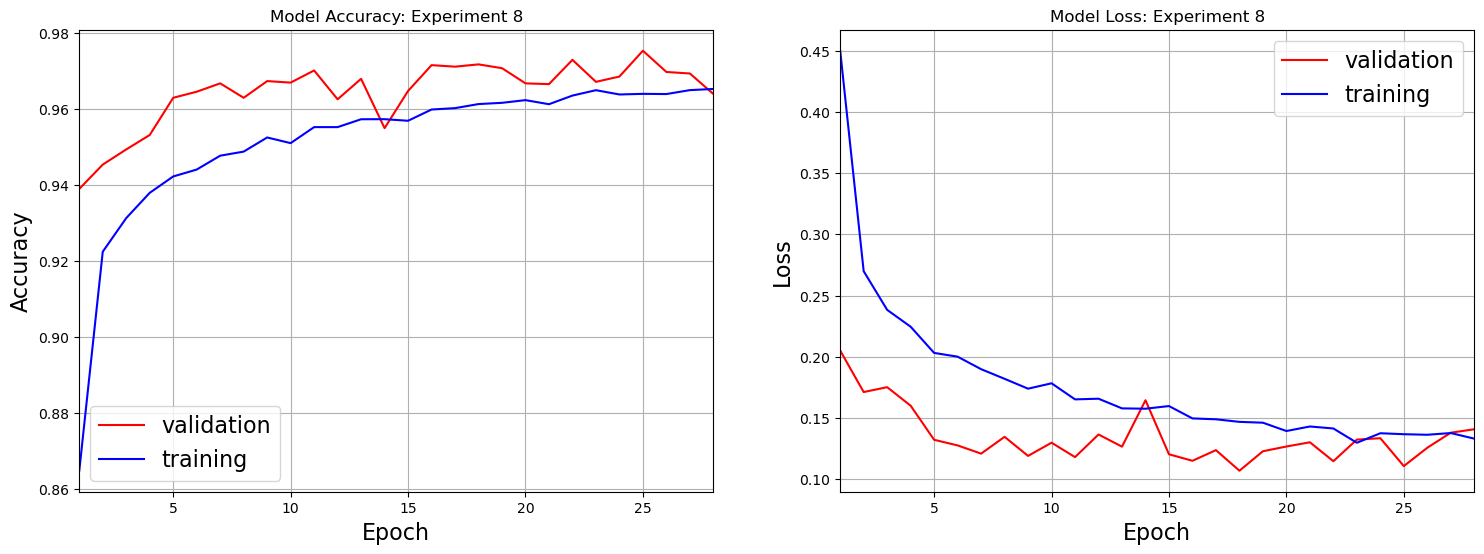

CPU times: total: 18min 23s
Wall time: 1min 30s


In [36]:
%%time
model_ex8, history_ex8 = training_wrapper(
    ex_num=8,
    model=model_ex8,
    n_epochs=50,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    early_stop_cb=early_stopping
)

### Evaluating Trained Model

In [37]:
y_pred_ex8 = evaluation_wrapper(
    ex_num=8,
    model=model_ex8,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 8...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.985
Test Accuracy: 0.972

Confusion Matrix:
[[ 964    0    4    0    1    1    4    3    2    1]
 [   0 1123    5    1    0    1    1    0    4    0]
 [   1    0 1011    4    4    1    1    6    2    2]
 [   2    0    9  975    0    8    0    5    5    6]
 [   1    0    1    0  956    0    6    4    1   13]
 [   4    0    0   11    0  866    4    2    3    2]
 [   5    3    1    0    4   17  922    1    5    0]
 [   1    1   13    1    2    2    0  999    1    8]
 [   3    1    8    2    8    5    2    5  935    5]
 [   1    4    0    8   13    3    2    6    3  969]]

***************************************************************************************
***************

## Experiment 9
Create a deep feed forward network with the following characteristics:
- 10 hidden layers each with 100 neurons
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): random_normal
- activation (hidden layers): relu
- Dropout (hidden layers): None
- Max 50 epochs with early exit

### Construct and Compile Model

In [38]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex9 = tf.keras.models.Sequential()
model_ex9.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

for i in range(10):
    model_ex9.add(
        tf.keras.layers.Dense(
            100, activation='relu', kernel_initializer='random_normal', name=f'hidden{i}'
        )
    )

model_ex9.add(
    tf.keras.layers.Dense(
        10, activation='softmax', kernel_initializer='random_normal', name='output'
    )
)

optimizer_ex9 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex9 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex9.compile(optimizer=optimizer_ex9, loss=loss_fn_ex9, metrics=['accuracy'])

model_ex9.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden0 (Dense)             (None, 100)               78500     
                                                                 
 hidden1 (Dense)             (None, 100)               10100     
                                                                 
 hidden2 (Dense)             (None, 100)               10100     
                                                                 
 hidden3 (Dense)             (None, 100)               10100     
                                                                 
 hidden4 (Dense)             (None, 100)               10100     
                                                                 
 hidden5 (Dense)             (None, 100)               1

### Train Model

Starting Experiment 9...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
1719/1719 [==============================] - 4s 2ms/step - loss: 2.3020 - accuracy: 0.1108 - val_loss: 2.3023 - val_accuracy: 0.1044
Epoch 2/50
1719/1719 [==============================] - 4s 2ms/step - loss: 2.3019 - accuracy: 0.1106 - val_loss: 2.3020 - val_accuracy: 0.1124
Epoch 3/50
1719/1719 [==============================] - 4s 2ms/step - loss: 2.3020 - accuracy: 0.1104 - val_loss: 2.3017 - val_accuracy: 0.1124
Epoch 4/50
1719/1719 [==============================] - 3s 2ms/step - loss: 2.3019 - accuracy: 0.1116 - val_loss: 2.3024 - val_accuracy: 0.1124
Epoch 5/50
1719/1719 [==============================] - 4s 2ms/step - loss: 2.3020 - accuracy: 0.1110 - val_loss: 2.3016 - val_accuracy: 

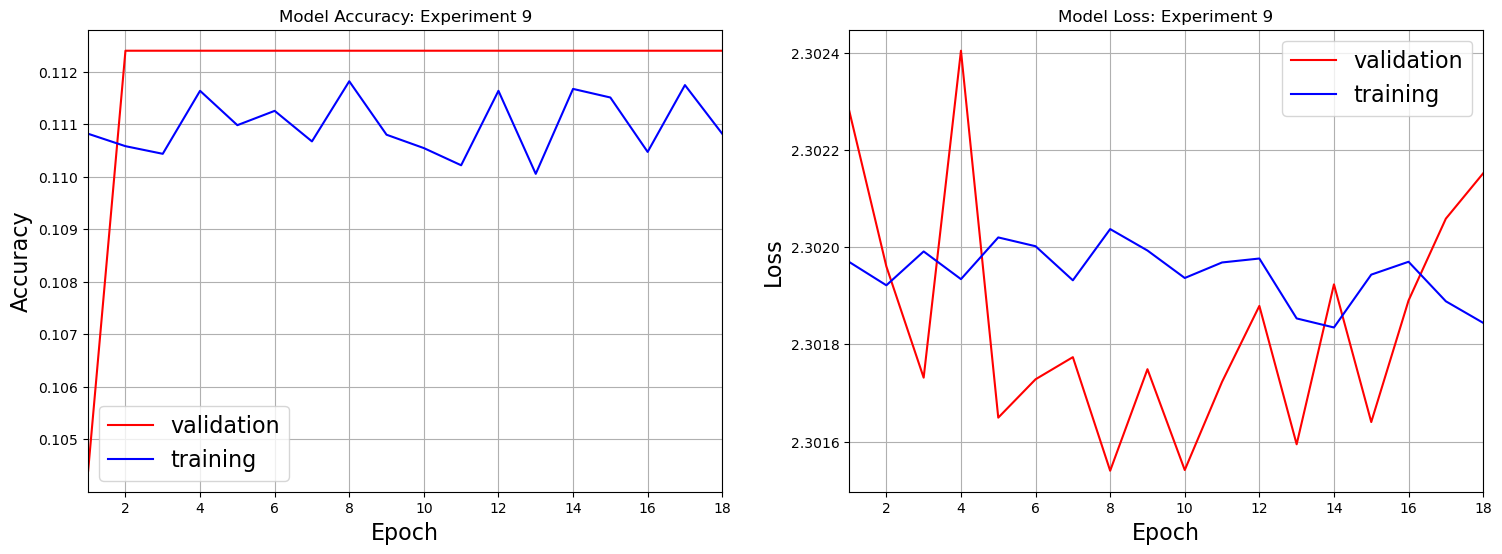

CPU times: total: 12min 37s
Wall time: 1min 2s


In [39]:
%%time
model_ex9, history_ex9 = training_wrapper(
    ex_num=9,
    model=model_ex9,
    n_epochs=50,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    early_stop_cb=early_stopping
)

### Evaluating Trained Model

In [40]:
y_pred_ex9 = evaluation_wrapper(
    ex_num=9,
    model=model_ex9,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 9...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.1124
Test Accuracy: 0.1135

Confusion Matrix:
[[   0  980    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0 1032    0    0    0    0    0    0    0    0]
 [   0 1010    0    0    0    0    0    0    0    0]
 [   0  982    0    0    0    0    0    0    0    0]
 [   0  892    0    0    0    0    0    0    0    0]
 [   0  958    0    0    0    0    0    0    0    0]
 [   0 1028    0    0    0    0    0    0    0    0]
 [   0  974    0    0    0    0    0    0    0    0]
 [   0 1009    0    0    0    0    0    0    0    0]]

***************************************************************************************
*************

## Experiment 10
Create a deep feed forward network with the following characteristics:
- 20 hidden layers each with 100 neurons
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): random_normal
- activation (hidden layers): relu
- Dropout (hidden layers): None
- Max 50 epochs with early exit

### Construct and Compile Model

In [41]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex10 = tf.keras.models.Sequential()
model_ex10.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

for i in range(20):
    model_ex10.add(
        tf.keras.layers.Dense(
            100, activation='relu', kernel_initializer='random_normal', name=f'hidden{i}'
        )
    )

model_ex10.add(
    tf.keras.layers.Dense(
        10, activation='softmax', kernel_initializer='random_normal', name='output'
    )
)

optimizer_ex10 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex10 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex10.compile(optimizer=optimizer_ex10, loss=loss_fn_ex10, metrics=['accuracy'])

model_ex10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden0 (Dense)             (None, 100)               78500     
                                                                 
 hidden1 (Dense)             (None, 100)               10100     
                                                                 
 hidden2 (Dense)             (None, 100)               10100     
                                                                 
 hidden3 (Dense)             (None, 100)               10100     
                                                                 
 hidden4 (Dense)             (None, 100)               10100     
                                                                 
 hidden5 (Dense)             (None, 100)               1

### Train Model

Starting Experiment 10...

**************************************************************************************
********************************    TRAINING MODEL    ********************************
**************************************************************************************
Epoch 1/50
1719/1719 [==============================] - 6s 3ms/step - loss: 2.3020 - accuracy: 0.1107 - val_loss: 2.3023 - val_accuracy: 0.1044
Epoch 2/50
1719/1719 [==============================] - 5s 3ms/step - loss: 2.3019 - accuracy: 0.1107 - val_loss: 2.3020 - val_accuracy: 0.1124
Epoch 3/50
1719/1719 [==============================] - 5s 3ms/step - loss: 2.3020 - accuracy: 0.1104 - val_loss: 2.3017 - val_accuracy: 0.1124
Epoch 4/50
1719/1719 [==============================] - 5s 3ms/step - loss: 2.3019 - accuracy: 0.1116 - val_loss: 2.3024 - val_accuracy: 0.1124
Epoch 5/50
1719/1719 [==============================] - 5s 3ms/step - loss: 2.3020 - accuracy: 0.1110 - val_loss: 2.3016 - val_accuracy:

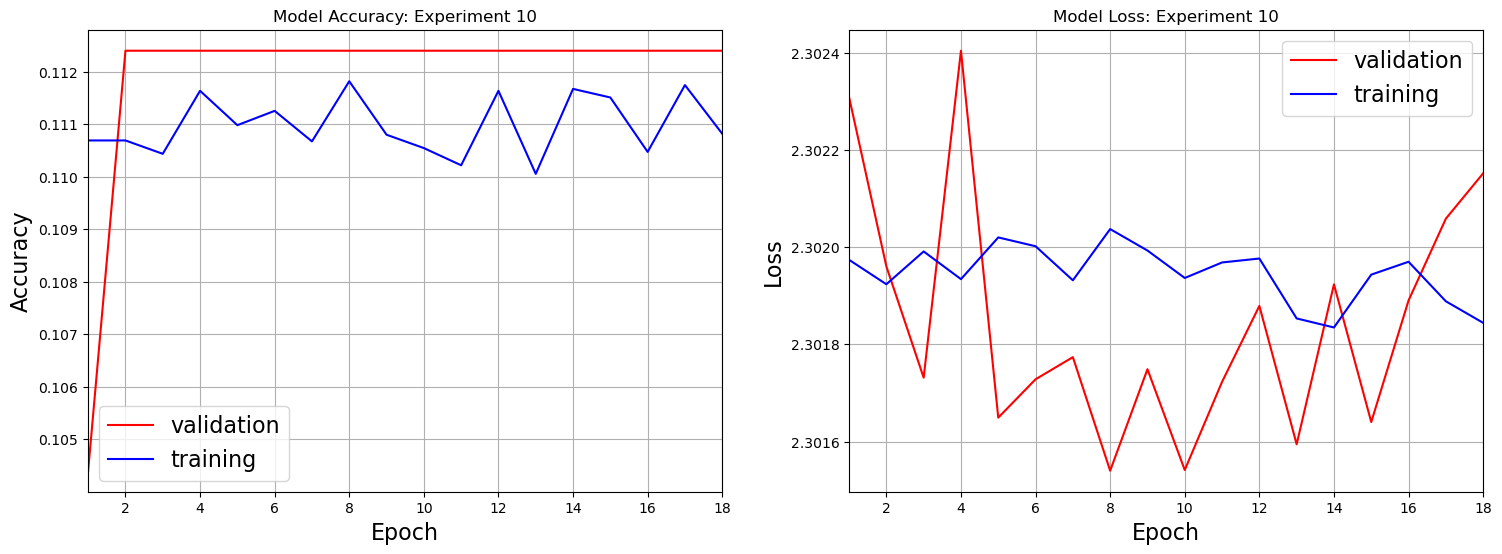

CPU times: total: 17min 59s
Wall time: 1min 28s


In [42]:
%%time
model_ex10, history_ex10 = training_wrapper(
    ex_num=10,
    model=model_ex10,
    n_epochs=50,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    early_stop_cb=early_stopping
)

### Evaluating Trained Model

In [43]:
y_pred_ex10 = evaluation_wrapper(
    ex_num=10,
    model=model_ex10,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    far_list=[0.01, 0.05, 0.1],
    plot_roc=False
)

Starting Evaluation for Experiment 10...

**************************************************************************************
***************************    EVALUATING TRAINED MODEL    ***************************
**************************************************************************************

Train Accuracy: 0.1124
Test Accuracy: 0.1135

Confusion Matrix:
[[   0  980    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0 1032    0    0    0    0    0    0    0    0]
 [   0 1010    0    0    0    0    0    0    0    0]
 [   0  982    0    0    0    0    0    0    0    0]
 [   0  892    0    0    0    0    0    0    0    0]
 [   0  958    0    0    0    0    0    0    0    0]
 [   0 1028    0    0    0    0    0    0    0    0]
 [   0  974    0    0    0    0    0    0    0    0]
 [   0 1009    0    0    0    0    0    0    0    0]]

***************************************************************************************
************

## Experiment 11
Create a deep feed forward network with the following characteristics:
- 4 hidden layers
    - Hidden layer 1: neurons=100
    - Hidden layer 2: neurons=300
    - Hidden layer 3: neurons=300
    - Hidden layer 4: neurons=100
- SGD Learning Rate: Determine an optimal value.
- kernel_initializer (all layers): Determine an optimal value.
- activation (hidden layers): Determine an optimal value.
- Dropout (hidden layers): Determine an optimal value.
- Max 50 epochs with early exit